In [1]:
import scipy as stats
import pandas as pd
from pandas_datareader import data as pdr
import seaborn as sns; sns.set()
import matplotlib
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import date, datetime
from openpyxl import Workbook, load_workbook
yf.pdr_override()

In [2]:
def cambio():
    #euro/dólar BRL=X
    pdr.get_data_yahoo('EURUSD=X', start='2022-01-27', end= date.today())
    pdr.get_data_yahoo('BRL=X', start='2022-01-27', end= date.today())
    
    
def commodities():
    #SOJA

    # ZS=F  << ticker

    pdr.get_data_yahoo('ZS=F', start='2022-01-27')
    #MILHO

    # ZC=F  << ticker

    pdr.get_data_yahoo('ZC=F', start='2022-01-27')
    #CAFÉ
     
    #  KC=F << ticker

    pdr.get_data_yahoo('KC=F', start='2022-01-27')



In [3]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data')

  selic_meta = consulta_bc(432)
  teste = set(list(selic_meta['valor']))
    ###
  ipca = consulta_bc(433)
  ipca= ipca.loc[ipca['data'] > '2002-01-01']
  ipca.plot(x = 'data', y='valor', figsize= (18,5))

  return df

In [4]:
class Rentabilidade:
    
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
# função para pegar a rentabilidade das ações desde o primeiro dia de investimento  

    def calc_rent_acao(self, acao_1,acao_2,acao_3,acao_4):
        
        cota = 100000000*0.3  ## valor em real
        
        acoes = [acao_1, acao_2, acao_3, acao_4]
        acao_open = pd.DataFrame()
        acao_close = pd.DataFrame()
        
        
        pesos = [0.25,0.25,0.25,0.25]
        
        
        for i in acoes:
            acao_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            acao_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
            
            
        rentabilidade = ((acao_close.iloc[-1]/acao_open.iloc[0]) - 1)
        
        retorno = round(np.dot(rentabilidade, pesos),2)
        
        return retorno
        
# função para pegar a rentabilidade das commodities desde o primeiro dia de investimento.

    def calc_rent_commodities(self, cmdts_1, cmdts_2, cmdts_3):
        
        cota = 100000000*0.2 ## valor em real

# pegando abertura e fechamento das commodities negociadas em dólar.

        commodities = [cmdts_1, cmdts_2, cmdts_3]
        cmdts_open = pd.DataFrame()
        cmdts_close = pd.DataFrame()

        for i in commodities:
            
            cmdts_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cmdts_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
            
            
# pegando a abertura e fechamento do par USD/BRL > dólar/real para calcular o valor da cota em dólar.
        cambio = ['BRL=X']
    
        cambio_open = pd.DataFrame()
        cambio_close = pd.DataFrame()

        for i in cambio:
            
            cambio_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cambio_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
        
#calculando a rentabilidade das commodities        
         
        rent_cambio = float(cambio_close.iloc[-1]/cambio_open.iloc[0])     
        rent_cmdts = cmdts_close.iloc[-1]/cmdts_open.iloc[0] 
        
        #rentabilidade referente a variação tanto das commodities quanto do dólar. Obs: a rent_cambio precisa ser
        #um valor float, pois a multiplicação é de um escalar por uma matriz, sendo necessário multiplicar cada coluna pelo escalar
        
        rentabilidade = rent_cambio*rent_cmdts - 1
        
        pesos = np.array([0.25, 0.25, 0.25])
        retorno = np.dot(rentabilidade, pesos)
          
        
       
        
        return round(retorno,4)
    
    def calc_rent_cambio(self, camb):
        
        ### cambio = ['BRL=X'] << USD/BRL
        
        cambio = [camb]
        
        cambio_open = pd.DataFrame()
        cambio_close = pd.DataFrame()

        for i in cambio:
            
            cambio_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cambio_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
        
        rent = (cambio_close.iloc[-1]/cambio_open.iloc[0])-1
        
        return rent
        
    def consulta_bc(self, codigo_bcb):
        url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
        df = pd.read_json(url)
        df['data'] = pd.to_datetime(df['data'], dayfirst=True)
        df = df.loc[df['data'] >= self.start]
        
        c = 5000000
        i= float(df.iloc[-1,1]/100)/252
        
        # Data inicial
        d2 = datetime.strptime(self.start, '%Y-%m-%d')
        # Data final
        d1 = datetime.strptime(self.end, '%Y-%m-%d')
        t = abs((d2 - d1).days)
    
        m = c*((1+i)**t)
        ret = m/c -1
        return round(ret,4)


    def calc_rent_etf(self, etf_1):
    
        etf = [etf_1]
        
# pegando abertura e fechamento dos etfs negociadas em dólar.

        etf_open = pd.DataFrame()
        etf_close = pd.DataFrame()

        for i in etf:
            
            etf_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            etf_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
            
            
# pegando a abertura e fechamento do par USD/BRL > dólar/real para calcular o valor da cota em dólar.
        cambio = ['BRL=X']
    
        cambio_open = pd.DataFrame()
        cambio_close = pd.DataFrame()

        for i in cambio:
            
            cambio_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cambio_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
        
#calculando a rentabilidade dos etf       
         
        rent_cambio = float(cambio_close.iloc[-1]/cambio_open.iloc[0])     
        rent_etf = etf_close.iloc[-1]/etf_open.iloc[0] 
        
        #rentabilidade referente a variação tanto das commodities quanto do dólar. Obs: a rent_cambio precisa ser
        #um valor float, pois a multiplicação é de um escalar por uma matriz, sendo necessário multiplicar cada coluna pelo escalar
        
        rentabilidade = rent_cambio*rent_etf - 1
        
        return rentabilidade

In [5]:
#rentabilidade de cada ativo
port = Rentabilidade('2022-01-28', '2022-02-10')

rent_acao = port.calc_rent_acao('GGBR4.SA','VALE3.SA','SUZB3.SA','BBDC4.SA')

rent_cmdt = port.calc_rent_commodities('ZS=F','ZC=F','KC=F')

rent_cambio_dolar = port.calc_rent_cambio('BRL=X')

rent_selic = port.consulta_bc(432)

rent_etf = port.calc_rent_etf('TLT')


acao =0.3
cmdt = 0.2
etf = 0.2
juros = 0.2
cambio = 0.1

pesos = np.array([acao,cmdt,etf,juros,cambio])

rentabilidades = np.array([rent_acao, rent_cmdt,rent_etf, rent_selic, rent_cambio_dolar])

rent_port = np.sum(np.dot(pesos, rentabilidades.T))



print("")
print(f'rentabilidade das acões no portfólio: {rent_acao*100*0.3}%')
print(f'rentabilidade das acões no período: {rent_acao*100}%')
print("")
print(f'rent do cambio no portifólio: {round(rent_cambio_dolar*100*0.1,3)}%')
print(f'rent do cambio no período: {round(rent_cambio_dolar*100,2)}%')
print("")
print(f'rentabilidade da selic no portfólio: {round((rent_selic*100*0.2),4)}%')
print(f'rentabilidade do juros no período: {round((rent_selic*100),4)}%')
print("")
print(f'rentabilidade da cmdt no portfólio: {round((rent_cmdt*100*0.2),4)}%')
print(f'rentabilidade do cmdt no período: {round((rent_cmdt*100),4)}%')

print("")
print(f'rentabilidade da etf no portfólio: {round((rent_etf*100*0.2),4)}%')
print(f'rentabilidade do etf no período: {round((rent_etf*100),4)}%')
print("")
print(rent_port)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/tmp/ipykernel_3141/1683764913.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rentabilidades = np.array([rent_acao, rent_cmdt,rent_etf, rent_selic, rent_cambio_dolar])


In [6]:
class Rentabilidade_1:
    
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
# função para pegar a rentabilidade das ações desde o primeiro dia de investimento  

    def calc_rent_acao(self, acao_1,acao_2,acao_3,acao_4):
        
        cota = 100000000*0.3  ## valor em real
        
        acoes = [acao_1, acao_2, acao_3, acao_4]
        acao_open = pd.DataFrame()
        acao_close = pd.DataFrame()
        
        
        pesos = [0.25,0.25,0.10,0.25]
        
        
        for i in acoes:
            acao_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            acao_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
            
            
        rentabilidade = ((acao_close.iloc[-1]/acao_open.iloc[0]) - 1)
        
        retorno = round(np.dot(rentabilidade, pesos),2)
        
        return retorno
        
# função para pegar a rentabilidade das commodities desde o primeiro dia de investimento.

    def calc_rent_commodities(self, cmdts_1, cmdts_2, cmdts_3):
        
        cota = 100000000*0.2 ## valor em real

# pegando abertura e fechamento das commodities negociadas em dólar.

        commodities = [cmdts_1, cmdts_2, cmdts_3]
        cmdts_open = pd.DataFrame()
        cmdts_close = pd.DataFrame()

        for i in commodities:
            
            cmdts_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cmdts_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
            
            
# pegando a abertura e fechamento do par USD/BRL > dólar/real para calcular o valor da cota em dólar.
        cambio = ['BRL=X']
    
        cambio_open = pd.DataFrame()
        cambio_close = pd.DataFrame()

        for i in cambio:
            
            cambio_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cambio_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
        
#calculando a rentabilidade das commodities        
         
        rent_cambio = float(cambio_close.iloc[-1]/cambio_open.iloc[0])     
        rent_cmdts = cmdts_close.iloc[-1]/cmdts_open.iloc[0] 
        
        #rentabilidade referente a variação tanto das commodities quanto do dólar. Obs: a rent_cambio precisa ser
        #um valor float, pois a multiplicação é de um escalar por uma matriz, sendo necessário multiplicar cada coluna pelo escalar
        
        rentabilidade = rent_cambio*rent_cmdts - 1
        
        pesos = np.array([0.25, 0.25, 0.25])
        retorno = np.dot(rentabilidade, pesos)
          
        
       
        
        return round(retorno,4)
    
    def calc_rent_cambio(self, camb):
        
        ### cambio = ['BRL=X'] << USD/BRL
        
        cambio = [camb]
        
        cambio_open = pd.DataFrame()
        cambio_close = pd.DataFrame()

        for i in cambio:
            
            cambio_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cambio_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
        
        rent = (cambio_close.iloc[-1]/cambio_open.iloc[0])-1
        
        return rent
        
    def consulta_bc(self, codigo_bcb):
        url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
        df = pd.read_json(url)
        df['data'] = pd.to_datetime(df['data'], dayfirst=True)
        df = df.loc[df['data'] >= self.start]
        
        c = 5000000
        i= float(df.iloc[-1,1]/100)/252
        
        # Data inicial
        d2 = datetime.strptime(self.start, '%Y-%m-%d')
        # Data final
        d1 = datetime.strptime(self.end, '%Y-%m-%d')
        t = abs((d2 - d1).days)
    
        m = c*((1+i)**t)
        ret = m/c -1
        return round(ret,4)


    def calc_rent_etf(self, etf_1):
    
        etf = [etf_1]
        
# pegando abertura e fechamento dos etfs negociadas em dólar.

        etf_open = pd.DataFrame()
        etf_close = pd.DataFrame()

        for i in etf:
            
            etf_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            etf_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
            
            
# pegando a abertura e fechamento do par USD/BRL > dólar/real para calcular o valor da cota em dólar.
        cambio = ['BRL=X']
    
        cambio_open = pd.DataFrame()
        cambio_close = pd.DataFrame()

        for i in cambio:
            
            cambio_open[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Open']
            cambio_close[i] = pdr.get_data_yahoo(i, start= self.start, end= self.end)['Adj Close']
        
#calculando a rentabilidade dos etf       
         
        rent_cambio = float(cambio_close.iloc[-1]/cambio_open.iloc[0])     
        rent_etf = etf_close.iloc[-1]/etf_open.iloc[0] 
        
        #rentabilidade referente a variação tanto das commodities quanto do dólar. Obs: a rent_cambio precisa ser
        #um valor float, pois a multiplicação é de um escalar por uma matriz, sendo necessário multiplicar cada coluna pelo escalar
        pesos = [0.5]
        rentabilidade = rent_cambio*rent_etf - 1
        rent = rentabilidade*0.5
        return rent

In [7]:
#rentabilidade de cada ativo
port = Rentabilidade_1('2022-01-28', '2022-02-24')

rent_acao = port.calc_rent_acao('GGBR4.SA','VALE3.SA','SUZB3.SA','BBDC4.SA')

rent_cmdt = port.calc_rent_commodities('ZS=F','ZC=F','KC=F')

rent_cambio_dolar = port.calc_rent_cambio('BRL=X')

rent_selic = port.consulta_bc(432)

rent_etf = port.calc_rent_etf('TLT')




acao =0.3
cmdt = 0.2
etf = 0.2
juros = 0.2
cambio = 0.1

pesos = np.array([acao,cmdt,etf,juros,cambio])

rentabilidades = np.array([rent_acao, rent_cmdt,rent_etf, rent_selic, rent_cambio_dolar])

rent_port = np.sum(np.dot(pesos, rentabilidades.T))



print("")
print(f'rentabilidade das acões no portfólio: {rent_acao*100*0.3}%')
print(f'rentabilidade das acões no período: {rent_acao*100}%')
print("")
print(f'rent do cambio no portifólio: {round(rent_cambio_dolar*100*0.1,3)}%')
print(f'rent do cambio no período: {round(rent_cambio_dolar*100,2)}%')
print("")
print(f'rentabilidade da selic no portfólio: {round((rent_selic*100*0.2),4)}%')
print(f'rentabilidade do juros no período: {round((rent_selic*100),4)}%')
print("")
print(f'rentabilidade da cmdt no portfólio: {round((rent_cmdt*100*0.2),4)}%')
print(f'rentabilidade do cmdt no período: {round((rent_cmdt*100),4)}%')

print("")
print(f'rentabilidade da etf no portfólio: {round((rent_etf*100*0.2),4)}%')
print(f'rentabilidade do etf no período: {round((rent_etf*100),4)}%')
print("")
print(rent_port)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/tmp/ipykernel_3141/652031605.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rentabilidades = np.array([rent_acao, rent_cmdt,rent_etf, rent_selic, rent_cambio_dolar])


In [8]:
hashdex = pdr.get_data_yahoo('HASH11.SA', start='2022-02-15', end='2022-02-17')


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HASH11.SA: No data found for this date range, symbol may be delisted


In [9]:
hashdex

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [10]:
acoes = ['TLT']

etf_open = pd.DataFrame()
etf_close = pd.DataFrame()
        

for i in acoes:
    etf_open[i] = pdr.get_data_yahoo(i, start= '2022-01-28', end= date.today())['Open']
    etf_close[i] = pdr.get_data_yahoo(i, start= '2022-01-28', end= date.today())['Adj Close']
            
            
        


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
etf_open.to_excel('etf_open.xlsx')

In [12]:
etf_close.to_excel('etf_close.xlsx')

In [13]:
def consulta_bc(codigo_bcb):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df = df.loc[df['data'] >= '2022-01-28']
    
    return df

In [14]:
consulta_bc(432)

,data,valor
8365,2022-01-28,9.25
8366,2022-01-29,9.25
8367,2022-01-30,9.25
8368,2022-01-31,9.25
8369,2022-02-01,9.25
8370,2022-02-02,9.25
8371,2022-02-03,10.75
8372,2022-02-04,10.75
8373,2022-02-05,10.75
8374,2022-02-06,10.75


In [4]:
val = 20000000*pow((1+0.0925/252),5)


In [5]:
val

20036733.3062209

In [7]:
val_2 = val*pow((1+0.1075/252),21)

In [8]:
val_2


20216996.820805185

In [9]:
val_2/20000000-1

0.010849841040259323

In [18]:
indice= [1,2,3,4,5]

In [30]:
rentabilidade = pd.DataFrame({'index':indice,'Juros':'0.84','ETF':'-17.28','Commodities':'2.59','dolar':'-7.50','acoes':'-5.31'})

In [25]:
rentabilidade

,index,Juros,ETF,Commodities,dolar,acoes
0,1,0.84,-17.28,2.59,-7.50,-5.31
1,2,0.84,-17.28,2.59,-7.50,-5.31
2,3,0.84,-17.28,2.59,-7.50,-5.31
3,4,0.84,-17.28,2.59,-7.50,-5.31
4,5,0.84,-17.28,2.59,-7.50,-5.31


In [31]:
plt.barplot(rentabilidade)

AttributeError: module 'matplotlib.pyplot' has no attribute 'barplot'

[*********************100%***********************]  1 of 1 completed


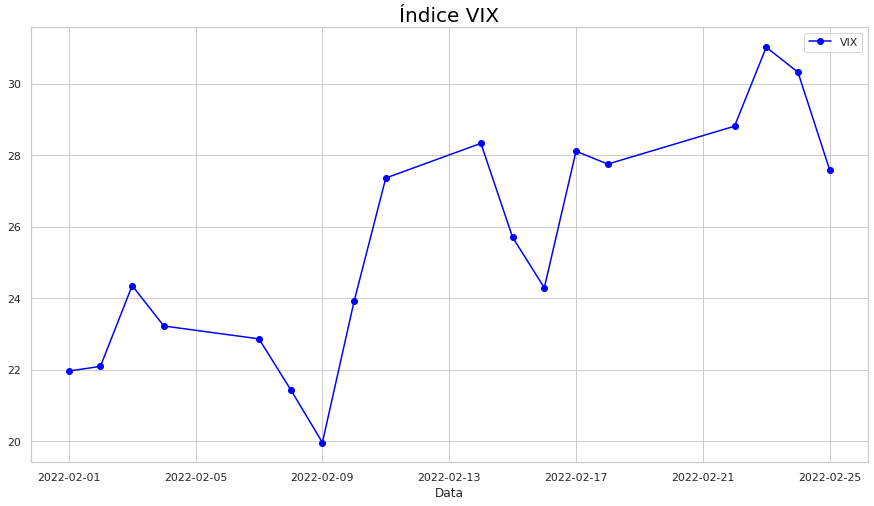

In [47]:
vix = pdr.get_data_yahoo("^VIX", start='2022-02-01')
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
plt.plot(vix['Adj Close'],'-o',color='blue', label= 'VIX')
plt.xlabel('Data')
plt.title('Índice VIX', fontsize=20,color='black')
plt.legend()
plt.show()